In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [87]:
# Data preparation function
def prepare_country_stats(oecd_bli, gdp_per_capita):
    """
    Prepare and merge OECD BLI data with GDP per capita data
    Returns: DataFrame with GDP per capita and Life satisfaction metrics
    """
    # Create copies to avoid SettingWithCopyWarning
    oecd_bli_copy = oecd_bli.copy()
    gdp_per_capita_copy = gdp_per_capita.copy()
    
    # Filter the data
    oecd_bli_filtered = oecd_bli_copy[oecd_bli_copy["INEQUALITY"]=="TOT"]
    
    # Pivot the data
    oecd_bli_pivoted = oecd_bli_filtered.pivot(
        index="Country",
        columns="Indicator",
        values="Value"
    )
    
    # Prepare GDP data
    gdp_per_capita_copy.rename(
        columns={"2015": "GDP per capita"},
        inplace=True
    )
    gdp_per_capita_copy.set_index("Country", inplace=True)
    
    # Merge the datasets
    full_country_stats = pd.merge(
        left=oecd_bli_pivoted,
        right=gdp_per_capita_copy,
        left_index=True,
        right_index=True
    )
    
    # Select columns and handle missing values
    required_columns = ["GDP per capita", "Life satisfaction"]
    country_stats = full_country_stats[required_columns].copy()  # Create a copy
    
    # Drop NA values and return
    return country_stats.dropna()  
    

In [89]:
# Load the data
oecd_bli = pd.read_csv("datasets/oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv("datasets/gdp_per_capita.csv",
                            thousands=',',
                            delimiter='\t',  # Tab-separated file
                            encoding='latin1',  # Special encoding for accents
                            na_values="n/a")  # Handle missing values

In [91]:
# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats['GDP per capita']]
y = np.c_[country_stats['Life satisfaction']]

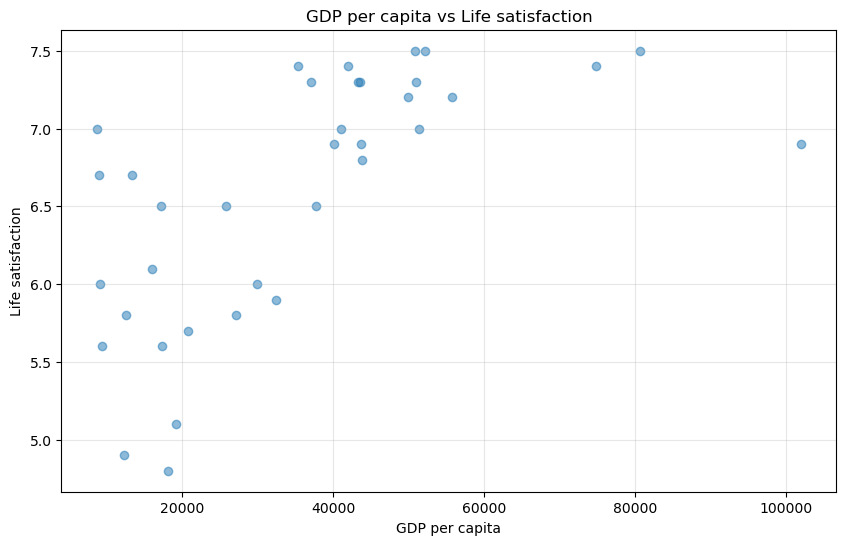

In [93]:
# Visualize the data
plt.figure(figsize=(10,6))
plt.scatter(X, y, alpha=0.5)
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.title("GDP per capita vs Life satisfaction")
plt.grid(True, alpha=0.3)

In [95]:
# Train the model
#model = LinearRegression()
# Create and train KNN model
# n_neighbors=3 means it will use the 3 closest neighbors for prediction
# Number of neighbors (k=3):
# Interpretation:
# - Each prediction uses 3 nearest countries
# - Small k: More sensitive to local patterns
# - Risk of overfitting with such a small k
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X,y)

KNeighborsRegressor(n_neighbors=3)

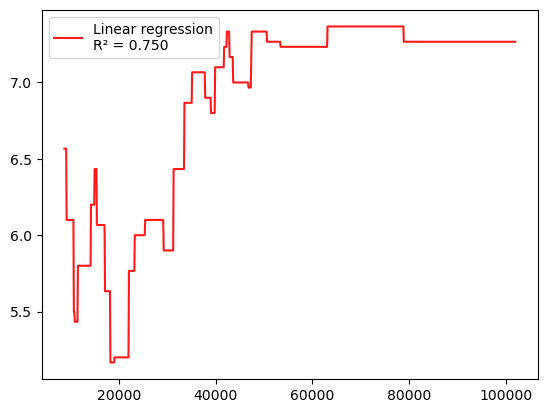

In [97]:
# Add regression line:
# Generate evenly spaced points for smooth line plotting
# np.linspace creates 1000 evenly spaced points between min and max GDP values
# reshape(-1, 1) converts the array to a 2D array required by sklearn
X_new = np.linspace(X.min(), X.max(), 1000).reshape(-1,1)

# Use trained model to predict life satisfaction for these GDP values
# This creates the y-coordinates for our regression line
y_new = model.predict(X_new)

# Plot the regression line
plt.plot(
    X_new, # X coordinates (GDP Values)
    y_new,# Y coordinates (Predicted life satisfaction)
    'r-', # Solid red line
    alpha=0.9,
    label=f'Linear regression\nR² = {model.score(X, y):.3f}' # Label with R² score
)
# Add legend to show R² score
plt.legend()

# Display the plot
plt.show()

In [99]:
# Make prediction for Cyprus
X_new = [[22587]]

# Use model to predict life satisfaction:
cyprus_prediction = model.predict(X_new)

In [101]:
"""
Print formatted prediction
cyprus_prediction[0][0] accesses:
- First (and only) prediction [0]
- First (and only) value in that prediction [0]
:.2f formats to 2 decimal places
"""
print(f"Predicted life satisfaction for Cyprus: {cyprus_prediction[0][0]:.2f}")

# Prediction for Cyprus: 5.77
# Interpretation:
# - Based on the 3 countries with most similar GDP to Cyprus
# - Predicts moderately high life satisfaction
# - More localized prediction than linear regression

Predicted life satisfaction for Cyprus: 5.77


In [105]:
"""
# Model evaluation section
print("\nModel Details:")
# Slope/Coefficient shows the change in life satisfaction per unit change in GDP
print(f"Slope (GDP coefficient): {model.coef_[0][0]:.6f}")
# Intercept is the predicted life satisfaction when GDP = 0
print(f"Intercept: {model.intercept_[0]:.3f}")
# R² (R-squared) indicates how well the model fits the data
# Range is 0 to 1, where 1 means perfect fit
print(f"R² Score: {model.score(X, y):.3f}")
"""
# Model evaluation
# Note: KNN doesn't have coefficients or intercept like linear regression
print("\nModel Details:")
print(f"Number of neighbors used: {model.n_neighbors}")
# 1. R² Score: 0.750 (compared to 0.404 from Linear Regression)
# Interpretation:
# - KNN explains 75% of variance in life satisfaction
# - Much better fit than linear regression (40.4%)
# - Suggests non-linear relationship between GDP and life satisfaction
print(f"R² Score: {model.score(X, y):.3f}")

# Additional KNN-specific information
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, model.predict(X))
# 2. Mean Squared Error (MSE): 0.151
# Interpretation:
# - Average squared difference between predictions and actual values
# - Lower values indicate better predictions
# - Used for comparing different models
print(f"Mean Squared Error: {mse:.3f}")
# 3. Root Mean Squared Error (RMSE): 0.389
# Interpretation:
# - Standard deviation of prediction errors
# - In same units as life satisfaction (0-10 scale)
# - On average, predictions are off by 0.389 points
print(f"Root Mean Squared Error: {np.sqrt(mse):.3f}")


Model Details:
Number of neighbors used: 3
R² Score: 0.750
Mean Squared Error: 0.151
Root Mean Squared Error: 0.389
